# Analysing baseball stats: Making predictions using linear and logistic regression 

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn import linear_model
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Data Preprocessing
Using game logs from 2016 MLB season as sample input to build a sequence of methods, which can be later used to process game logs from multiple seasons to construct our training and test sets.

In [2]:
# read game logs taken from retrosheet into a pandas dataframe 

input_df = pd.read_table("game_data/GL2016.TXT", sep=",", header=None)

The dataset is unlablled.
So, we label the columns of interest to make it readable.
This [web page](http://www.retrosheet.org/gamelogs/glfields.txt) on retrosheet provides detail of what each column represents.

In [3]:
# method to label columns
def label_cols(input_df):
    input_df.rename(columns = {3: 'Visiting Team', 6: 'Home Team', 9: 'Visitor Score', 10: 'Home Score'}, inplace=True)
    return input_df

# call the function to label columns of interest
input_df = label_cols(input_df)

# use the head function to look the first few rows of the dataframe
input_df.head()

,0,1,2,Visiting Team,4,5,Home Team,7,8,Visitor Score,...,151,152,153,154,155,156,157,158,159,160
0,20160403,0,Sun,NYN,NL,1,KCA,AL,1,3,...,Salvador Perez,2,infao001,Omar Infante,4,fuenr001,Reymond Fuentes,9,NaN,Y
1,20160403,0,Sun,TOR,AL,1,TBA,AL,1,5,...,Steven Souza,9,kierk001,Kevin Kiermaier,8,congh001,Hank Conger,2,NaN,Y
2,20160403,0,Sun,SLN,NL,1,PIT,NL,1,1,...,Josh Harrison,4,mercj002,Jordy Mercer,6,lirif001,Francisco Liriano,1,NaN,Y
3,20160404,0,Mon,CHN,NL,1,ANA,AL,1,9,...,Andrelton Simmons,6,perec003,Carlos Perez,2,giavj001,Johnny Giavotella,4,NaN,Y
4,20160404,0,Mon,MIN,AL,1,BAL,AL,1,2,...,J.J. Hardy,6,schoj001,Jonathan Schoop,4,rickj001,Joey Rickard,7,NaN,Y


In [4]:
# method to add new columns to indicate the winning team
def add_new_cols(input_df):
    input_df['Home Win'] = (input_df['Home Score'] > input_df['Visitor Score'])
    input_df['Visitor Win'] = (input_df['Visitor Score'] > input_df['Home Score'])
    return input_df

# call the function to add the new column
input_df = add_new_cols(input_df)

input_df.head()

,0,1,2,Visiting Team,4,5,Home Team,7,8,Visitor Score,...,153,154,155,156,157,158,159,160,Home Win,Visitor Win
0,20160403,0,Sun,NYN,NL,1,KCA,AL,1,3,...,infao001,Omar Infante,4,fuenr001,Reymond Fuentes,9,NaN,Y,True,False
1,20160403,0,Sun,TOR,AL,1,TBA,AL,1,5,...,kierk001,Kevin Kiermaier,8,congh001,Hank Conger,2,NaN,Y,False,True
2,20160403,0,Sun,SLN,NL,1,PIT,NL,1,1,...,mercj002,Jordy Mercer,6,lirif001,Francisco Liriano,1,NaN,Y,True,False
3,20160404,0,Mon,CHN,NL,1,ANA,AL,1,9,...,perec003,Carlos Perez,2,giavj001,Johnny Giavotella,4,NaN,Y,False,True
4,20160404,0,Mon,MIN,AL,1,BAL,AL,1,2,...,schoj001,Jonathan Schoop,4,rickj001,Joey Rickard,7,NaN,Y,True,False


In [10]:
# method to group data by home team and compute relevant statistics
def proc_home_team_data(input_df):
    # group by home team
    home_group = input_df.groupby(input_df['Home Team'])
    # compute no of games, runs scored, runs conceded, wins, run differential
    home_df = home_group[['Visitor Score', 'Home Score', 'Home Win']].apply(sum)
    home_df['Home Games'] = home_group['Home Win'].count()
    home_df['Run Differential at Home'] = home_df['Home Score'] - home_df['Visitor Score']
    home_df.index.rename('Team', inplace = True)
    home_df.reset_index(inplace = True)
    return home_df

home_df = proc_home_team_data(input_df)

home_df.head()

,Team,Visitor Score,Home Score,Home Win,Home Games,Run Differential at Home
0,ANA,351.0,337.0,40.0,81,-14.0
1,ARI,493.0,411.0,33.0,81,-82.0
2,ATL,404.0,335.0,31.0,81,-69.0
3,BAL,336.0,376.0,50.0,81,40.0
4,BOS,380.0,477.0,47.0,81,97.0


In [11]:
# method to group data by visiting team and compute relevant statistics
def proc_vis_team_data(input_df):
    visit_group = input_df.groupby(input_df['Visiting Team'])
    visit_df = visit_group[['Visitor Score', 'Home Score', 'Visitor Win']].apply(sum)
    visit_df['Road Games'] = visit_group['Visitor Win'].count()
    visit_df['Run Differential as Visitor'] = visit_df['Visitor Score'] - visit_df['Home Score']
    visit_df.index.rename('Team', inplace = True)
    visit_df.reset_index(inplace = True)
    return visit_df

visit_df = proc_vis_team_data(input_df)

visit_df.head()

,Team,Visitor Score,Home Score,Visitor Win,Road Games,Run Differential as Visitor
0,ANA,380.0,376.0,34.0,81,4.0
1,ARI,341.0,397.0,36.0,81,-56.0
2,ATL,314.0,375.0,37.0,80,-61.0
3,BAL,368.0,379.0,39.0,81,-11.0
4,BOS,401.0,314.0,46.0,81,87.0


In [12]:
# method to group dataframes with stats grouped by home and visiting teams 
# and to explicitly compute explanatory and response variables

def merge_data_frames(home_df, visit_df):
    overall_df = home_df.merge(visit_df, how = 'outer', left_on = 'Team', right_on = 'Team')
    overall_df['RD'] = overall_df['Run Differential at Home'] + overall_df['Run Differential as Visitor']
    overall_df['Win Percentage'] = (overall_df['Home Win'] + overall_df['Visitor Win'])/(overall_df['Home Games'] + overall_df['Road Games'])
    
    return overall_df

overall_df = merge_data_frames(home_df, visit_df)

overall_df.head()

,Team,Visitor Score_x,Home Score_x,Home Win,Home Games,Run Differential at Home,Visitor Score_y,Home Score_y,Visitor Win,Road Games,Run Differential as Visitor,RD,Win Percentage
0,ANA,351.0,337.0,40.0,81,-14.0,380.0,376.0,34.0,81,4.0,-10.0,0.456790
1,ARI,493.0,411.0,33.0,81,-82.0,341.0,397.0,36.0,81,-56.0,-138.0,0.425926
2,ATL,404.0,335.0,31.0,81,-69.0,314.0,375.0,37.0,80,-61.0,-130.0,0.422360
3,BAL,336.0,376.0,50.0,81,40.0,368.0,379.0,39.0,81,-11.0,29.0,0.549383
4,BOS,380.0,477.0,47.0,81,97.0,401.0,314.0,46.0,81,87.0,184.0,0.574074


### Collate all data preprocessing steps

In [13]:
# method to collate all data preprocessing steps, streamlines our processing of game logs
def extract_linear_reg_inputs(input_df):
    # rename columns
    input_df = label_cols(input_df)
    # add new cols
    input_df = add_new_cols(input_df)
    # group and process data by home team
    home_df = proc_home_team_data(input_df)
    # group and process data by visiting team
    visit_df = proc_vis_team_data(input_df)
    # merge home and visitor dataframes
    overall_df = merge_data_frames(home_df, visit_df)
    return overall_df


## Step 2: Model construction and Evaluation

### Constructing the training set

In [29]:
# get training data from 2011-2016 to train the linear regression model

# initialize arrays to hold the training data
train_run_diff = np.empty([0, 1])
train_win_perc = np.empty([0, 1])

for year in range(2011, 2017):
    # log file name from which to extract the data
    log_file = "game_data/GL" + str(year) + ".TXT"
    
    # read log into a dataframe
    df = pd.read_table(log_file, sep = ",", header = None)
    
    # extract relevant stats into a new dataframe
    df_proc = extract_linear_reg_inputs(df)

    # add to the training set
    # np.vstack => vertically stack the values 
    # df.values.reshape => reshape the output values, [-1, 1] = (size * 1)
    train_run_diff = np.vstack([train_run_diff, df_proc['RD'].values.reshape([-1, 1])])
    train_win_perc = np.vstack([train_win_perc, df_proc['Win Percentage'].values.reshape([-1, 1])])


### Building the model and interpreting the paramters

In [33]:
# instantiate an object for the linear regression model, LR class imported from scikit-learn
lin_reg = linear_model.LinearRegression(fit_intercept = True)

In [34]:
# compute model paramters with the training data
lin_reg.fit(train_run_diff, train_win_perc)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [35]:
# access and display the model paramters
print("Slope (a) = ", float(lin_reg.coef_), " Intercept (b) = ", float(lin_reg.intercept_))

Slope (a) =  0.0006339906190979562  Intercept (b) =  0.4999614986492969


In [37]:
# get the regression score (R-squared), value b/w 0 and 1, 1.0 indicates perfect fit
r_squared = lin_reg.score(train_run_diff, train_win_perc)
print("R-squared for the linear regression fit = ", r_squared)

R-squared for the linear regression fit =  0.8550222313345784


### Visualizing the test data
- Visually exploring the relationships between the response and explanatory variables is an important step in model construction and aids in good feature selection.

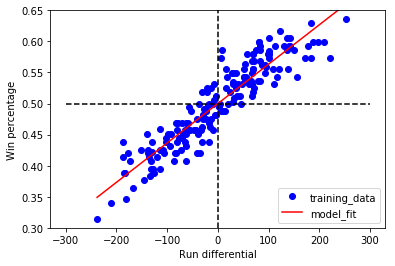

In [52]:
x_ax = np.array(range(int(np.min(train_run_diff)), int(np.max(train_run_diff)))).reshape(-1, 1)
y_ax = lin_reg.coef_ * x_ax + lin_reg.intercept_

plt.plot(train_run_diff, train_win_perc, 'bo', label = "training_data")
plt.plot(x_ax, y_ax, 'r', label = "model_fit")

plt.plot([-300, 300], [0.5, 0.5], "k--")
plt.plot([0, 0], [0.30, 0.65], "k--")
plt.ylim([0.30, 0.65])

plt.xlabel("Run differential")
plt.ylabel("Win percentage")
plt.legend(loc = "lower right")
plt.show()

- An interesting observation drawn from the aid of the visualization is that a team with 0-run differential is expected to win roughly half of its games as it should be the case.